<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/code/tf_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
IMG_SIZE = 512

drive.mount('/content/drive')

path = '/content/drive/MyDrive/dissertation_seg_data'

input_path = os.path.join(path,"input_resize_patches/")

mask_path = os.path.join(path,"mask_resize_patches/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
def parse_image(image_path):
    mask_path = tf.strings.regex_replace(image_path, "image", "labels")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)

    # 29 - Black (Road)
    # 76 - Grey (Building)
    # 255 - White (Other)
    
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    mask = tf.where(mask == 76, np.dtype('uint8').type(1), mask)
    mask = tf.where(mask == 29, np.dtype('uint8').type(2), mask)
    mask = tf.where(tf.math.logical_and(tf.math.logical_and(mask != 0, mask != 1), mask != 2), np.dtype('uint8').type(0), mask)

    return {'image' : image, 'segmentation_mask': mask}

In [21]:
train_dataset = tf.data.Dataset.list_files(input_path + "*.png")

train_size = 0.8 * train_dataset.cardinality().numpy()

validation_size = 0.1 * train_dataset.cardinality().numpy()

train_ds = train_dataset.take(train_size)

extra = train_dataset.skip(train_size)  

val_ds = extra.take(validation_size)

test_ds = extra.skip(validation_size)

train_ds = train_ds.map(parse_image)

test_ds = test_ds.map(parse_image)

val_ds = val_ds.map(parse_image)

In [22]:
def load_image_train(datapoint):

    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image = tf.cast(image, tf.float32) / 255.0

    return image, mask

def load_image_test(datapoint):

    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    image = tf.cast(image, tf.float32) / 255.0

    return image, mask

In [23]:
BATCH_SIZE = 16

BUFFER_SIZE = 1000

dataset = {"train": train_ds, "test": test_ds, "val": val_ds}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size=BUFFER_SIZE, seed=47).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['test'] = dataset['test'].map(load_image_test).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [24]:
def convolutional_layer_block(previous_layer, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(previous_layer)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

def u_net(img_shape, n_classes, filter_start):
    inputs = Input(shape=img_shape)
    previous_layer = inputs

    filter_list = [filter_start, filter_start * 2, filter_start * 4, filter_start * 8]
    print(filter_list)

    concatenate_link = []
    for filter_size in filter_list:
        x = convolutional_layer_block(previous_layer, filter_size, (3,3))
        concatenate_link.append(x)
        x = MaxPooling2D((2, 2))(x)
        previous_layer = x

    concatenate_link = list(reversed(concatenate_link))
    x = convolutional_layer_block(previous_layer, 256, (3,3))
    previous_layer = x

    for count,filter_size in enumerate(reversed(filter_list)):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(previous_layer)
        x = concatenate([x, concatenate_link[count]], axis = 3)
        convolutional_layer_block(x, filter_size, (3,3))
        previous_layer = x

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(previous_layer)

    return Model(inputs=inputs, outputs=outputs)

model = u_net((IMG_SIZE, IMG_SIZE, 3), n_classes = 3, filter_start = 32)

[32, 64, 128, 256]


In [25]:
model.compile(optimizer=Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 32  0           ['conv2d_19[0][0]']              
                                )                                                           

In [27]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+"large_epoch_building_roads_model_e100_bs4.h5"), verbose = 1, save_best_only=True, save_weights_only=False)]

In [28]:
EPOCHS = 100

length_data = train_ds.cardinality().numpy()

length_val = val_ds.cardinality().numpy()

STEPS_PER_EPOCH = length_data // BATCH_SIZE

VALIDATION_STEPS = length_val // BATCH_SIZE

In [29]:
# Use if model fail and train again
# model = keras.model.load_model("/content/drive/MyDrive/"+"large_epoch_building_roads_model_e10_bs8.h5")

model_history = model.fit(dataset['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=dataset['val'], callbacks = callbacks)

Epoch 1/100
469/469 [==============================] - ETA: 0s - loss: 0.7689 - accuracy: 0.6554
Epoch 1: val_loss improved from inf to 0.67513, saving model to /content/drive/MyDrive/large_epoch_building_roads_model_e100_bs4.h5
469/469 [==============================] - 299s 513ms/step - loss: 0.7689 - accuracy: 0.6554 - val_loss: 0.6751 - val_accuracy: 0.7037
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.7418
Epoch 2: val_loss improved from 0.67513 to 0.56535, saving model to /content/drive/MyDrive/large_epoch_building_roads_model_e100_bs4.h5
469/469 [==============================] - 163s 348ms/step - loss: 0.6025 - accuracy: 0.7418 - val_loss: 0.5654 - val_accuracy: 0.7610
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7735
Epoch 3: val_loss improved from 0.56535 to 0.54842, saving model to /content/drive/MyDrive/large_epoch_building_roads_model_e100_bs4.h5
469/469 [==========================

In [30]:
model.save("/content/drive/MyDrive/"+"large_epoch_building_roads_model_e100_bs4.h5")

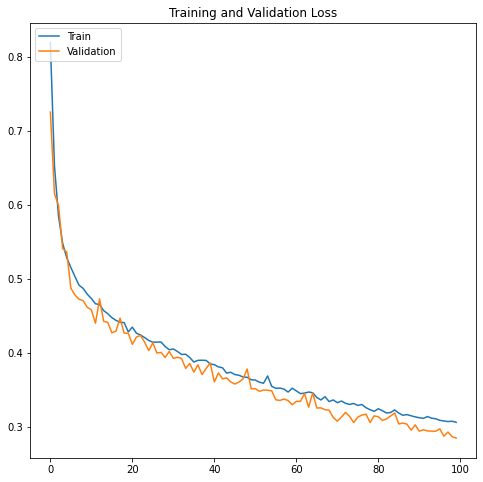

In [60]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()

plot_training_data("Training and Validation Loss", loss, val_loss)

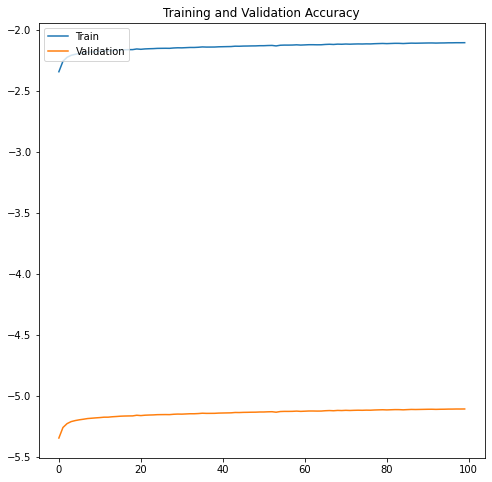

In [61]:
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

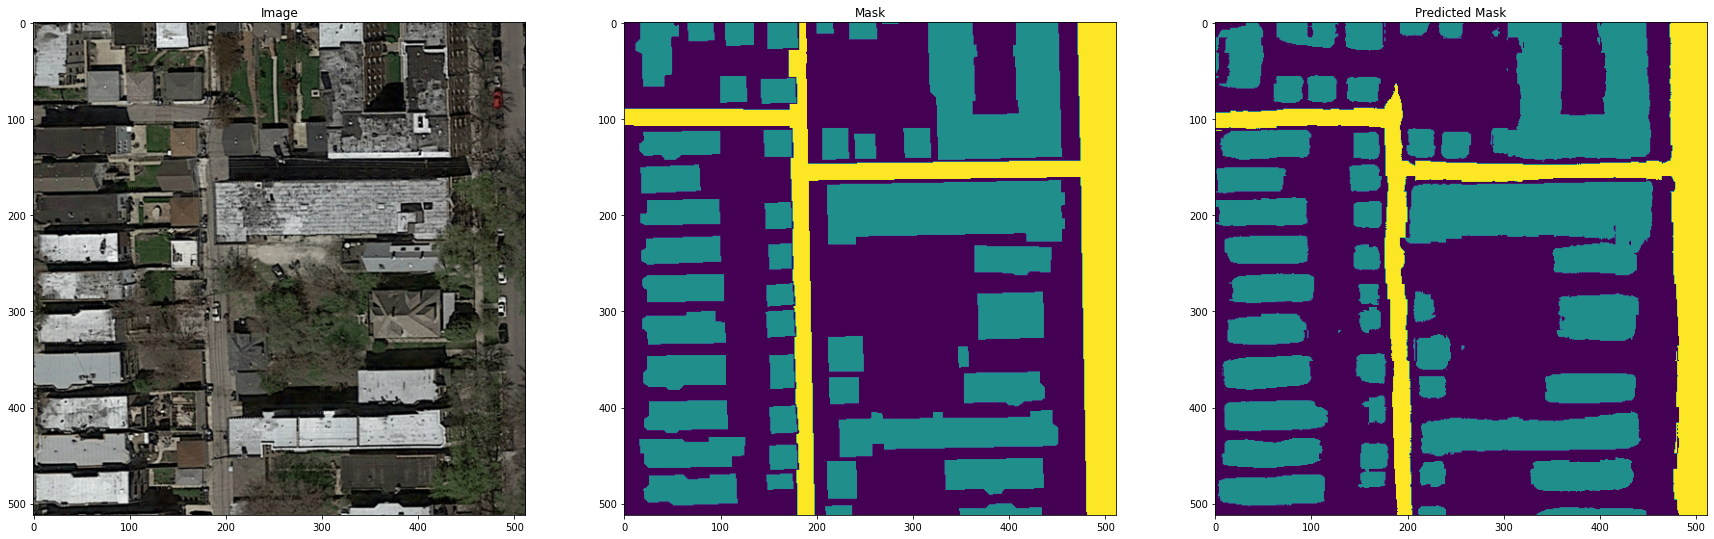

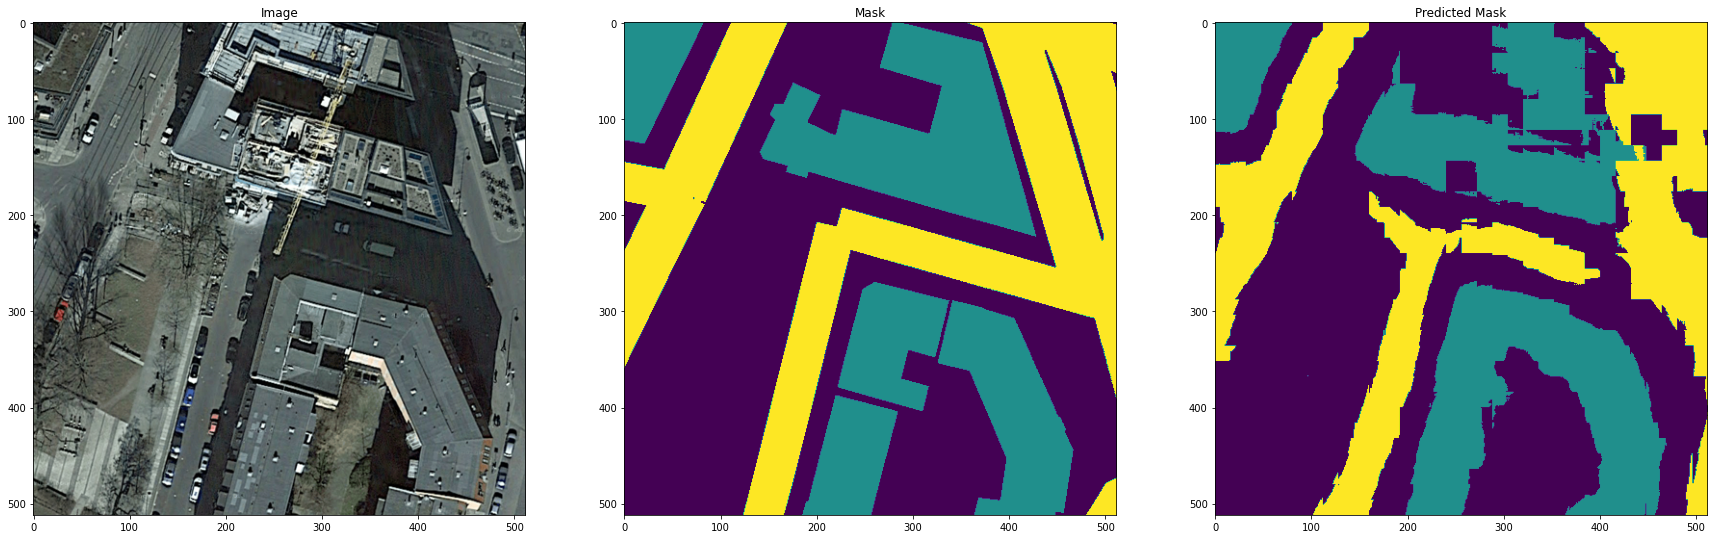

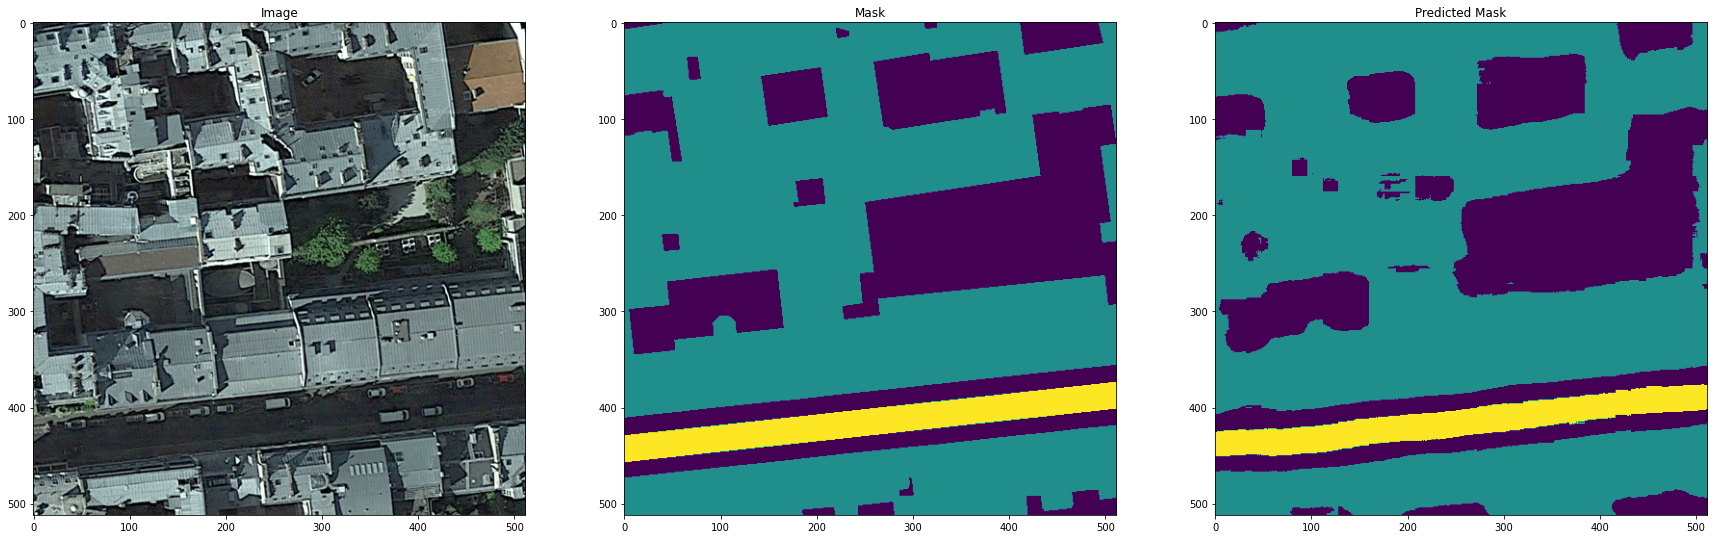

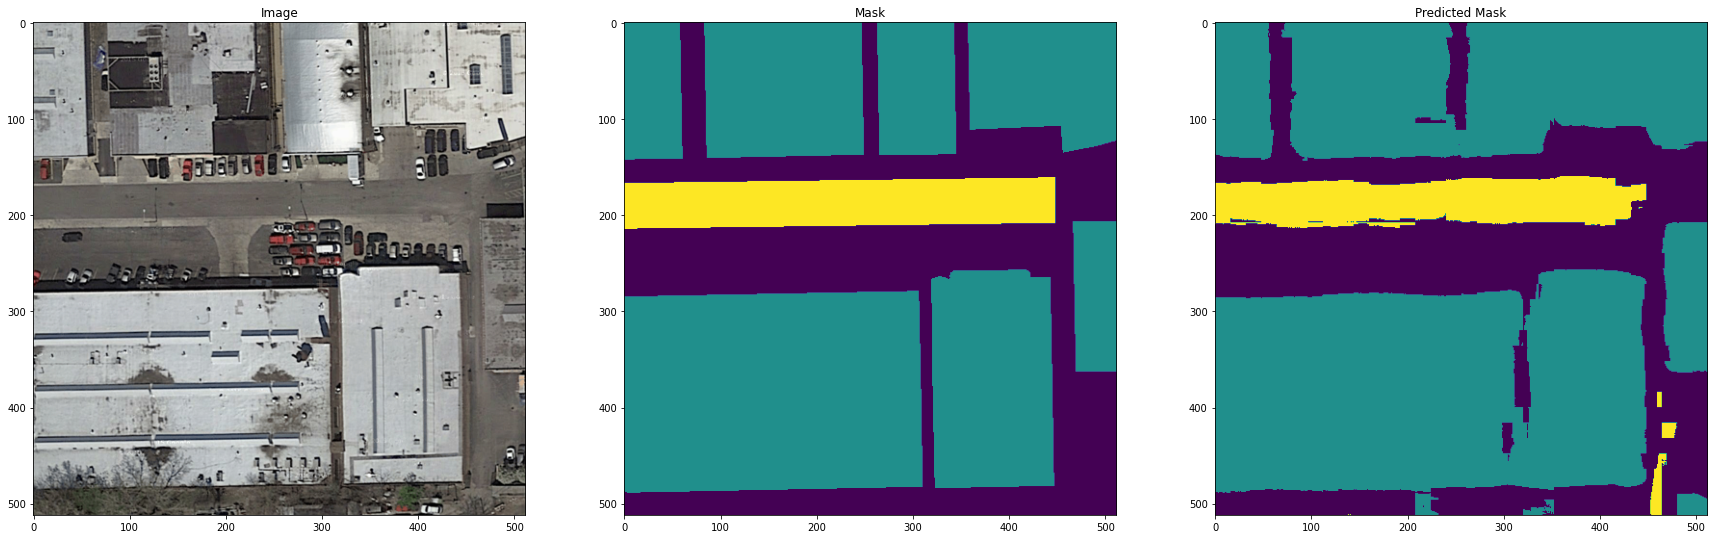

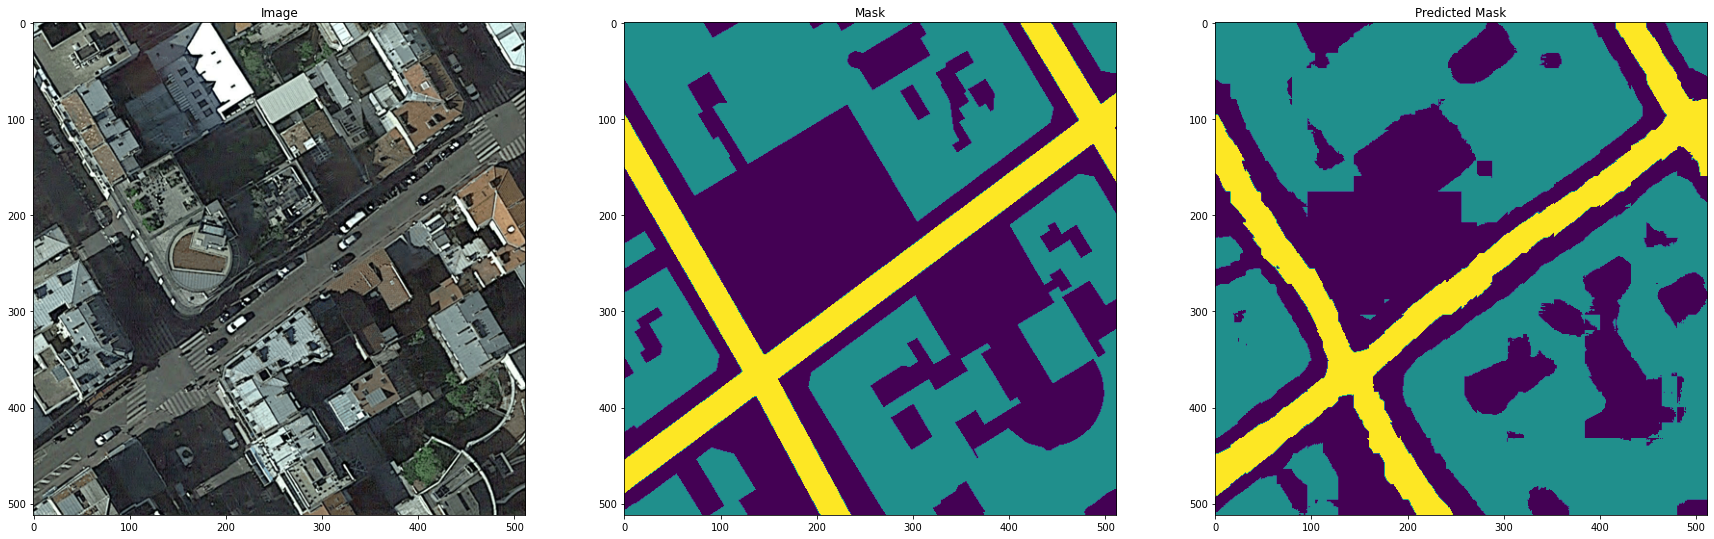

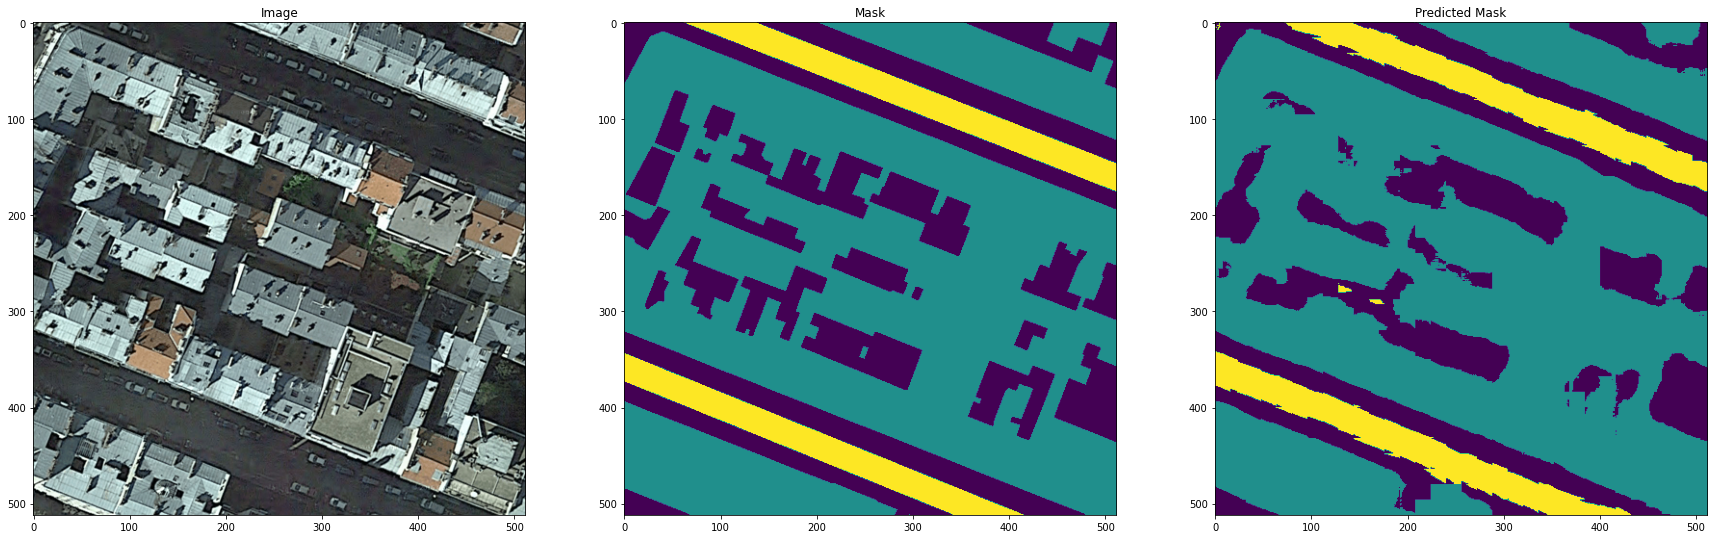

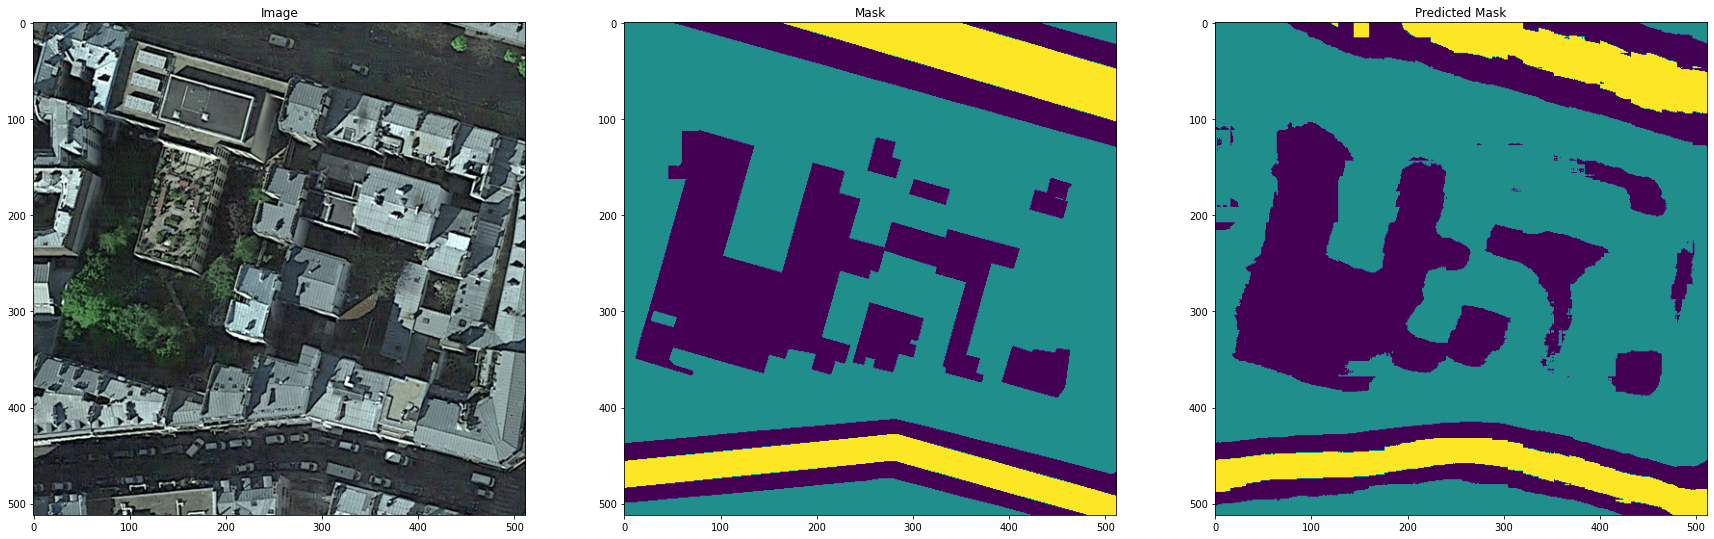

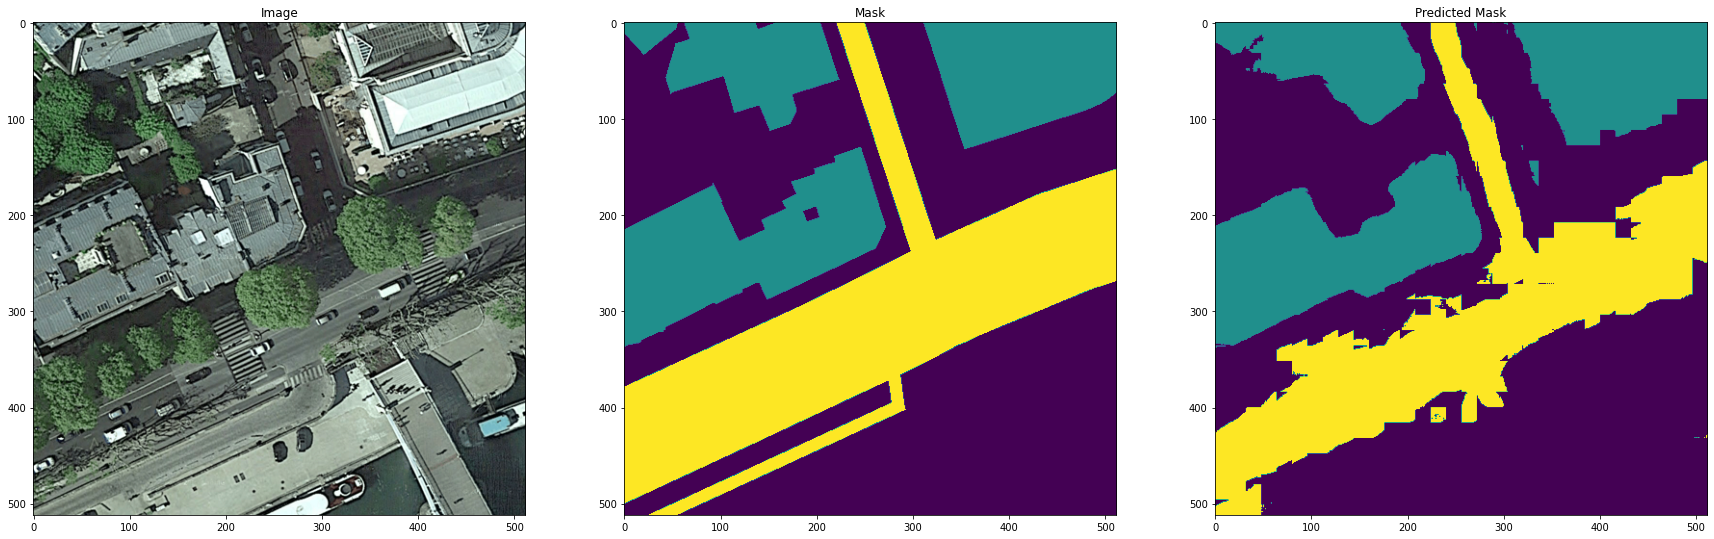

In [58]:
def display_predictions(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,3,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))
    plt.title('Predicted Mask')
    plt.show()

def format_prediction(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

for image, mask in dataset['test'].take(1):
    for img_idx in range(8):
        pred_mask = model.predict(image)
        pred_mask = format_prediction(pred_mask[img_idx])
        display_predictions(image[img_idx], mask[img_idx], pred_mask)